In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf, to_date, dayofweek, hour, lag, mean, lit, when,avg
from pyspark.sql.window import Window
import json
from pyspark.sql.functions import rand, isnan, when
from pyspark.sql.types import FloatType
from pyspark.sql.functions import rand, round
from keras.callbacks import TensorBoard
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense

from sklearn.preprocessing import MinMaxScaler
import numpy as np
import datetime
from tensorflow.keras.utils import to_categorical

# Initialize a SparkSession
spark = SparkSession.builder.appName("PredictiveMaintenance").getOrCreate()

# Load your dataset into a PySpark DataFrame
df = spark.read.csv('/Users/mac/Downloads/predictive2.csv', header=True, inferSchema=True)
df.count()
df = df.limit(100000)
df.count()
# Assuming 'date_insertion' is the correct timestamp column based on your dataset schema
# Adjust the following transformations accordingly:

# Extract JSON fields function
def extract_from_json(column, key):
    try:
        json_data = json.loads(column.replace("'", "\""))
        return json_data.get(key, None)
    except:
        return None

# Registering the UDF
extract_from_json_udf = udf(extract_from_json)

# Step 1: Extracting 'oil_value' and 'fuel_liters'
df = df.withColumn("oil_value", extract_from_json_udf(col("details"), lit("oil_value")))
df = df.withColumn("fuel_liters", extract_from_json_udf(col("details"), lit("fuel_liters")))

# Step 2: Creating time-based features
df = df.withColumn("date_insertion", to_date(col("date_insertion")))
df = df.withColumn("day_of_week", dayofweek(col("date_insertion")))
df = df.withColumn("hour_of_day", hour(col("date_insertion")))



# Step 4: Aggregate readings on a daily basis
daily_avg_df = df.groupBy("thing_id", "date_insertion").agg(mean("power_supply_voltage").alias("daily_avg_voltage"))
df = df.join(daily_avg_df, ["thing_id", "date_insertion"], "left")

# Step 5: Create binary indicator for 'engine_status'
df = df.withColumn("engine_alert", when(col("engine_status") == "Abnormal", 1).otherwise(0))

# Define a UDF to generate random values within a range
def random_value(min_value, max_value):
    return (rand() * (max_value - min_value) + min_value).cast(FloatType())

# random_value_udf = udf(random_value, FloatType())

# Set min and max values for 'oil_value' and 'fuel_liters'
oil_value_min, oil_value_max = 0, 4
fuel_liters_min, fuel_liters_max = 0, 60

fuel_liters_mi, fuel_liters_ma = 2, 6


# Replace null values with random numbers
# Replace null values with random numbers and round to 1 decimal place
df = df.withColumn("oil_value", when(df['oil_value'].isNull(), round((rand() * (oil_value_max - oil_value_min) + oil_value_min), 1)).otherwise(df['oil_value']))
df = df.withColumn("fuel_liters", when(df['fuel_liters'].isNull(), round((rand() * (fuel_liters_max - fuel_liters_min) + fuel_liters_min), 1)).otherwise(df['fuel_liters']))
# df = df.withColumn("fuel_change", when(df['fuel_liters'].isNull(), round((rand() * (fuel_liters_ma - fuel_liters_mi) + fuel_liters_mi), 1)).otherwise(df['fuel_liters']))








# Step 6: Generate interaction features
# df = df.withColumn("voltage_current_interaction", col("power_supply_voltage") * col("battery_current"))

# Step 3: Calculating rate of change for 'battery_current'
windowSpec = Window.partitionBy("thing_id").orderBy("date_insertion")
df = df.withColumn("battery_current_change", col("power_supply_voltage") - lag("power_supply_voltage", 1).over(windowSpec))


24/05/11 13:31:04 WARN Utils: Your hostname, MacBook-Air-de-mac.local resolves to a loopback address: 127.0.0.1; using 192.168.1.7 instead (on interface en0)
24/05/11 13:31:04 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/11 13:31:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = df.select("thing_id", "date_insertion", "speed", "total_km", "engine_status", "power_supply_voltage" ,"oil_value", "fuel_liters",  "battery_current_change", "daily_avg_voltage")


from pyspark.sql import Window
from pyspark.sql.functions import lag, avg, stddev

# Define a window
window = Window.orderBy('date_insertion').rowsBetween(-9, 0)  # assuming 'date_insertion' is your time column

# Calculate rolling averages and standard deviations
# df = df.withColumn('speed_avg', avg(df['speed']).over(window))
# df = df.withColumn('oil_value_std', stddev(df['oil_value']).over(window))

# Calculate changes between consecutive readings
# df = df.withColumn('speed_change', df['speed'] - lag(df['speed']).over(Window.orderBy('date_insertion')))
# df = df.withColumn('fuel_change', df['fuel_liters'] - lag(df['fuel_liters']).over(Window.orderBy('date_insertion')))
df = df.withColumn('fuel_change', (rand() * 4 + 2).cast("int"))#replace all fuel_chnages values with random values between 2 and 6



# Step 7: Calculate rolling average


# Define a Window specification
# windowSpec = Window.orderBy('date_insertion').rowsBetween(-4, 0)  # 5 rows including current row

# Calculate rolling average
# df = df.withColumn('oil_quality_rolling_avg', avg(df['oil_value']).over(windowSpec))

# Show the first 5 rows of the DataFrame
df.show()


+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+
|thing_id|date_insertion|speed| total_km|engine_status|power_supply_voltage|oil_value|fuel_liters|battery_current_change|daily_avg_voltage|fuel_change|
+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+
|     802|    2024-02-28|    0|275680962|            0|               19.91|      1.5|       34.4|                  NULL|22.23008032128516|          2|
|     802|    2024-02-28|    0|275680962|            0|                19.9|      2.1|       30.2|  -0.01000000000000...|22.23008032128516|          2|
|     802|    2024-02-28|    0|275680962|            0|               19.88|      0.2|       33.7|  -0.01999999999999...|22.23008032128516|          5|
|     802|    2024-02-28|    0|275680962|            0|               19.87|      2.7|  

In [3]:
# Define thresholds
oil_value_fail_threshold = 1
oil_value_about_to_fail_threshold = 2

df = df.withColumn("car_age", when(rand() < 0.7, "old").otherwise("new"))

df = df.withColumn("last_oil_change", 
                   when(rand() < 0.25, "new")
                   .when((rand() >= 0.25) & (rand() < 0.5), "50km")
                   .when((rand() >= 0.5) & (rand() < 0.75), "80km")
                   .otherwise("old"))

                #    when((col("fuel_change") > 30) , "fail")


                #     when((col("fuel_change") > 5)  & (col("car_age") == "new"), "about fail")
                #    .when((col("fuel_change") > 4)& (col("car_age") == "old"), "about fail")
                #    .when((col("car_age") == "old") & (col("last_oil_change") == "80km"), "about to fail")
                #    .when((col("car_age") == "new") & ((col("last_oil_change") == "new") | (col("last_oil_change") == "50km") | (col("last_oil_change") == "80km")), "normal")

df = df.withColumn("status", 
                    when((col("fuel_change") > 30) , "fail")
                    .when((col("fuel_change") > 5)  & (col("car_age") == "new"), "about fail")
                   .when((col("fuel_change") > 4)& (col("car_age") == "old"), "about fail")
                   .when((col("car_age") == "old") & (col("last_oil_change") == "80km"), "about to fail")
                   .when((col("car_age") == "new") & ((col("last_oil_change") == "new") | (col("last_oil_change") == "50km") | (col("last_oil_change") == "80km")), "normal")
                   .when((col("car_age") == "old") & (col("last_oil_change") == "old"), "fail")
                   .when((col("car_age") == "old") & ((col("last_oil_change") == "new") | (col("last_oil_change") == "50km")), "normal")
                   .otherwise("about to fail"))

# df = df.drop("date_insertion", "speed",)



from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import random

# Define a UDF that changes "about to fail" to "fail" with a 5% probability
def change_status(status):
    if status == "fail" and random.random() < 0.2:
        return "Noraml"
    
    # if status == "normal" and random.random() < 0.06:
    #     return "fail"
    else:
        return status

change_status_udf = udf(change_status, StringType())

# Apply the UDF to the "status" column
df = df.withColumn("status", change_status_udf(df["status"]))


df.show()


+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+-------+---------------+-------------+
|thing_id|date_insertion|speed| total_km|engine_status|power_supply_voltage|oil_value|fuel_liters|battery_current_change|daily_avg_voltage|fuel_change|car_age|last_oil_change|       status|
+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+-------+---------------+-------------+
|     802|    2024-02-28|    0|275680962|            0|               19.91|      1.5|       34.4|                  NULL|22.23008032128516|          2|    old|            old|         fail|
|     802|    2024-02-28|    0|275680962|            0|                19.9|      2.1|       30.2|  -0.01000000000000...|22.23008032128516|          2|    old|            old|         fail|
|     802|    2024-02-28|    0|275680962|         

In [4]:
from pyspark.ml.feature import StringIndexer
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from pyspark.ml.feature import OneHotEncoder



df = df.withColumn("status", 
                   when(col("status") == "normal", 0)
                   .when(col("status") == "about to fail", 1)
                   .otherwise(2))

df = df.withColumn("car_age", 
                   when(col("car_age") == "old", 0)
                   .when(col("car_age") == "new", 1)



)


df = df.withColumn("last_oil_change", 
                   when(col("last_oil_change") == "new", 0)
                   .when(col("last_oil_change") == "50km", 1)
                   .when(col("last_oil_change") == "80km", 2)
                   .otherwise(3))

df.show(3)

# Cast 'statusIndex' to integer

# Select features and label
features = df.drop('status')
label = df.select('status')

# Convert Spark DataFrame to pandas DataFrame
features_pd = features.toPandas()
label_pd = label.toPandas()


# Remove rows with any null value
features_pd = features_pd.dropna()
label_pd = label_pd.loc[features_pd.index] 

# Remove 'thing_id' and 'date' from features
features_pd = features_pd.drop(['thing_id', 'date_insertion','speed','total_km','battery_current_change','daily_avg_voltage'], axis=1)

features_pd.head()


# Convert pandas DataFrame to NumPy array
features_array = features_pd.values
label_array = label_pd.values

# Convert labels to one-hot encoded format
label_array = to_categorical(label_array, num_classes=3)

# Scale features to range [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features_array)



# Reshape to 3D array (batch_size, timesteps, input_dim)
scaled_features = np.reshape(scaled_features, (scaled_features.shape[0], 1, scaled_features.shape[1]))

+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+-------+---------------+------+
|thing_id|date_insertion|speed| total_km|engine_status|power_supply_voltage|oil_value|fuel_liters|battery_current_change|daily_avg_voltage|fuel_change|car_age|last_oil_change|status|
+--------+--------------+-----+---------+-------------+--------------------+---------+-----------+----------------------+-----------------+-----------+-------+---------------+------+
|     802|    2024-02-28|    0|275680962|            0|               19.91|      1.5|       34.4|                  NULL|22.23008032128516|          2|      0|              3|     2|
|     802|    2024-02-28|    0|275680962|            0|                19.9|      2.1|       30.2|  -0.01000000000000...|22.23008032128516|          2|      0|              3|     2|
|     802|    2024-02-28|    0|275680962|            0|               19.88|      0.2

In [8]:
df.head()

Row(thing_id=802, date_insertion=datetime.date(2024, 2, 28), speed=0, total_km=275680962, engine_status=0, power_supply_voltage=19.91, oil_value='1.5', fuel_liters='34.4', battery_current_change=None, daily_avg_voltage=22.23008032128516, fuel_change=2, car_age=0, last_oil_change=3, status=2)

In [9]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# # Assemble your features
# assembler = VectorAssembler(
#     inputCols=["engine_status", "power_supply_voltage", "oil_value","fuel_liters","fuel_change","car_age","last_oil_change"],
#     outputCol="status"
# )
# df = assembler.transform(df)

# Convert labels DataFrame to a series
labels = label_pd.iloc[:, 0]

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_pd, labels, test_size=0.2, random_state=42)

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

print(f"Model accuracy: {accuracy}")

Model accuracy: 1.0


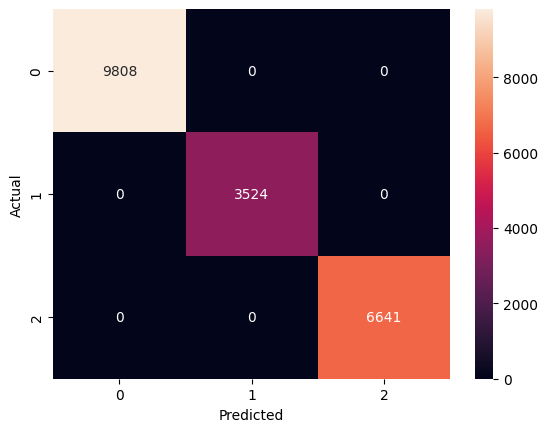

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

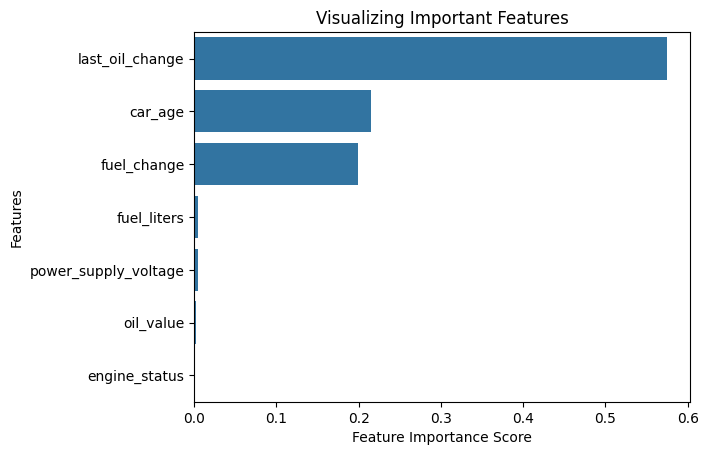

In [15]:
import pandas as pd

feature_imp = pd.Series(clf.feature_importances_,index=features_pd.columns).sort_values(ascending=False)

sns.barplot(x=feature_imp, y=feature_imp.index)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [16]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

ValueError: multiclass format is not supported